In [1]:
import pandas as pd
import numpy as np
from collections import Counter

# 读取训练师数据
trainer_df = pd.read_excel("Full_data.xlsx")
# 统计所有标签
all_specialities = []
for item in trainer_df['specialities'].dropna():
    tags = [t.strip() for t in str(item).split(',')]
    all_specialities.extend(tags)
speciality_counts = Counter(all_specialities)
speciality_list = list(speciality_counts.keys())
speciality_freqs = np.array([speciality_counts[s] for s in speciality_list])
speciality_probs = speciality_freqs / speciality_freqs.sum()  # 概率归一化

# 生成用户ID
num_users = 10000
user_ids = [f"u{str(i+1).zfill(6)}" for i in range(num_users)]

np.random.seed(42)
rows = []
for user_id in user_ids:
    # 每个用户最多有3个兴趣标签，且至少有1个
    n_goals = np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
    user_goals = np.random.choice(speciality_list, size=n_goals, replace=False, p=speciality_probs)
    main_goal = user_goals[0]
    filter_price = np.random.choice(["low to high", "high to low"], p=[0.6, 0.4])
    # 主兴趣、兴趣列表、价格偏好
    rows.append([user_id, main_goal, ','.join(user_goals), filter_price])

df = pd.DataFrame(rows, columns=["user_id", "main_goal", "goal_list", "filter_price"])
df.to_csv("user_filter.csv", index=False)


In [9]:
import pandas as pd
import numpy as np

num_users = 10000
min_recs = 30
max_recs = 40
interest_rec_rate = 0.7  # 70%兴趣相关，多标签更合理

# 读取数据
user_filter = pd.read_csv("user_filter.csv")
trainer_info = pd.read_excel("Full_data.xlsx")
trainer_score = pd.read_excel("New_User.xlsx",sheet_name="Scored")

trainer_info['trainer_id'] = trainer_info['trainer_id'].astype(str)
trainer_score['trainer_id'] = trainer_score['trainer_id'].astype(str)
trainers = pd.merge(trainer_info, trainer_score[['trainer_id','Final_Score']], on='trainer_id', how='left')

# 建立标签-训练师映射
speciality_trainers = {}
for idx, row in trainers.iterrows():
    for spec in str(row['specialities']).split(','):
        spec = spec.strip()
        if spec not in speciality_trainers:
            speciality_trainers[spec] = []
        speciality_trainers[spec].append(row['trainer_id'])

all_trainer_ids = set(trainers['trainer_id'])

rows = []
np.random.seed(42)
for idx, u in user_filter.iterrows():
    user_id = u['user_id']
    goal_list = str(u['goal_list']).split(',')
    # 合并所有兴趣相关训练师（去重）
    rel_trainers = set()
    for goal in goal_list:
        rel_trainers.update(speciality_trainers.get(goal, []))
    rel_trainers = list(rel_trainers)
    other_trainers = list(all_trainer_ids - set(rel_trainers))
    n_total = np.random.randint(min_recs, max_recs + 1)
    n_rel = int(n_total * interest_rec_rate)
    n_other = n_total - n_rel
    trainers_sel = []
    if len(rel_trainers) > n_rel:
        trainers_sel += list(np.random.choice(rel_trainers, n_rel, replace=False))
    else:
        trainers_sel += rel_trainers
        n_other += n_rel - len(rel_trainers)
    if len(other_trainers) > n_other:
        trainers_sel += list(np.random.choice(other_trainers, n_other, replace=False))
    else:
        trainers_sel += other_trainers
    # 行为生成
    for trainer_id in trainers_sel:
        trainer_row = trainers.loc[trainers['trainer_id'] == trainer_id].iloc[0]
        score = trainer_row['Final_Score'] if not pd.isnull(trainer_row['Final_Score']) else 3.5
        is_interest = trainer_id in rel_trainers
        # 点击概率
        if is_interest and score > 4.3:
            click_p = 0.85
        elif is_interest and score > 3.7:
            click_p = 0.65
        elif is_interest:
            click_p = 0.3
        else:
            click_p = 0.12  # 非相关提升多样性
        click = np.random.rand() < click_p
        if not click:
            rows.append([user_id, trainer_id, 0, 0, 0])
            continue
        # watch分布
        if score > 4.3:
            watch = np.clip(np.random.normal(0.87, 0.07), 0, 1)
        elif score > 3.7:
            watch = np.clip(np.random.normal(0.72, 0.12), 0, 1)
        else:
            watch = np.clip(np.random.normal(0.55, 0.18), 0, 1)
        # like分布
        if watch > 0.8:
            like = np.clip(np.random.normal(0.87, 0.10), 0, watch)
        elif watch > 0.6:
            like = np.clip(np.random.normal(0.7, 0.15), 0, watch)
        else:
            like = np.clip(np.random.normal(0.4, 0.14), 0, watch)
        rows.append([user_id, trainer_id, 1, round(watch, 2), round(like, 2)])

df = pd.DataFrame(rows, columns=["user_id", "trainer_id", "click", "watch", "like"])
df.to_csv("user_behavior.csv", index=False)


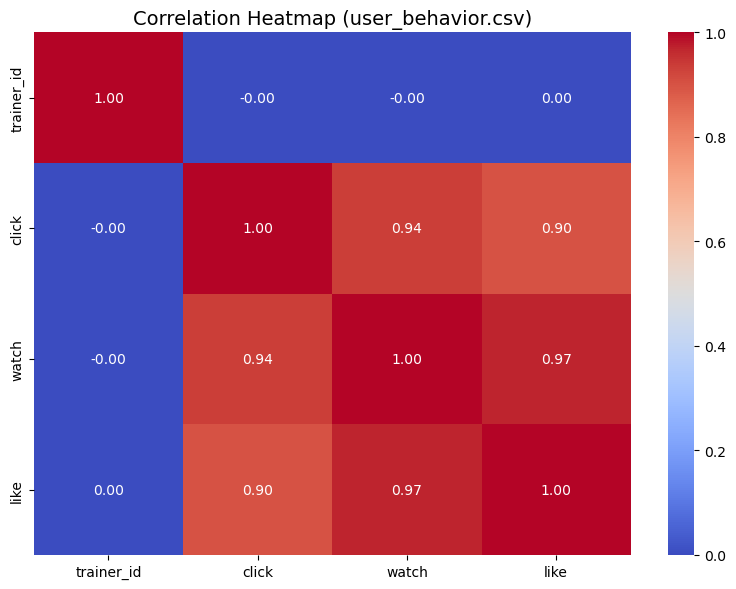

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取第一段代码生成的数据
df = pd.read_csv("user_behavior.csv")

# 只取数值型列 (click, watch, like)
num_cols = df.select_dtypes(include=["number"])

# 计算相关系数矩阵
corr = num_cols.corr()

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (user_behavior.csv)", fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np

# -------------------------
# 全局设置
# -------------------------
np.random.seed(42)

num_users = 10000
min_recs = 30
max_recs = 40
interest_rec_rate = 0.7  # 70% 兴趣相关

# -------------------------
# 读取数据
# -------------------------
user_filter = pd.read_csv("user_filter.csv")

# 用 Full_data 提供基础字段：athlete_rating、specialities 等
trainer_info = pd.read_excel("Full_data.xlsx")
trainer_info['trainer_id'] = trainer_info['trainer_id'].astype(str)

# 用 New_User 只提取 Final_Score（用于排序，不参与行为仿真）
trainer_score = pd.read_excel("New_User.xlsx", sheet_name="Scored")
trainer_score.columns = trainer_score.columns.str.strip()
trainer_score['trainer_id'] = trainer_score['trainer_id'].astype(str)

# 合并两个数据源：以 trainer_id 为主键
trainers = pd.merge(
    trainer_info[['trainer_id', 'athlete_rating', 'specialities']],  # 行为相关字段
    trainer_score[['trainer_id', 'Final_Score']],                    # 评分用于排序
    on='trainer_id', how='left'
)

# -------------------------
# 工具函数
# -------------------------
def clean_specs(s):
    if pd.isna(s): return []
    return [t.strip().lower() for t in str(s).split(',') if t.strip()]

def rating_bucket(r):
    """基于评分划分质量档位"""
    if r > 4.3:
        return 3
    elif r > 3.7:
        return 2
    else:
        return 1

def click_watch_params(bucket, is_interest):
    """点击率 + 观看分布参数（来自你原设定）"""
    if bucket == 3:
        return (0.85 if is_interest else 0.18, 0.87, 0.07)
    elif bucket == 2:
        return (0.65 if is_interest else 0.15, 0.72, 0.12)
    else:
        return (0.30 if is_interest else 0.12, 0.55, 0.18)

# -------------------------
# 建立辅助映射
# -------------------------
# 1) speciality → trainers
speciality_trainers = {}
for _, row in trainers.iterrows():
    tid = row['trainer_id']
    for spec in clean_specs(row['specialities']):
        speciality_trainers.setdefault(spec, []).append(tid)

all_trainer_ids = set(trainers['trainer_id'])

# 2) trainer_id → rating/bucket
trainer_rating_map = {}
for _, row in trainers.iterrows():
    tid = row['trainer_id']
    rating = row.get('athlete_rating', 3.0)
    bucket = rating_bucket(rating)
    trainer_rating_map[tid] = {'rating': rating, 'bucket': bucket}

# -------------------------
# 生成推荐行为数据
# -------------------------
rows = []

for _, u in user_filter.iterrows():
    uid = u['user_id']
    goals = [t.strip().lower() for t in str(u['goal_list']).split(',') if t.strip()]
    
    # 兴趣相关教练
    rel = set()
    for g in goals:
        rel.update(speciality_trainers.get(g, []))
    rel = list(rel)

    others = list(all_trainer_ids - set(rel))
    n_total = np.random.randint(min_recs, max_recs + 1)
    n_rel = int(round(n_total * interest_rec_rate))
    n_other = n_total - n_rel

    chosen_rel = list(np.random.choice(rel, size=min(n_rel, len(rel)), replace=False)) if rel else []
    n_other += max(0, n_rel - len(chosen_rel))

    chosen_other = list(np.random.choice(others, size=min(n_other, len(others)), replace=False)) if others else []
    chosen = list(dict.fromkeys(chosen_rel + chosen_other))

    # 不足再兜底补足
    if len(chosen) < n_total:
        gap = n_total - len(chosen)
        gap_fill = np.random.choice(list(all_trainer_ids), size=gap, replace=True)
        chosen += list(gap_fill)

    chosen = chosen[:n_total]
    rel_set = set(rel)

    # 行为仿真
    for tid in chosen:
        info = trainer_rating_map.get(tid, {'rating': 3.0, 'bucket': 2})
        is_interest = tid in rel_set
        click_p, mu, sigma = click_watch_params(info['bucket'], is_interest)
        clicked = (np.random.rand() < click_p)

        if not clicked:
            rows.append([uid, tid, 0, 0, 0])
            continue

        watch = float(np.clip(np.random.normal(mu, sigma), 0, 1))
        if watch > 0.8:
            like = np.clip(np.random.normal(0.87, 0.10), 0, watch)
        elif watch > 0.6:
            like = np.clip(np.random.normal(0.70, 0.15), 0, watch)
        else:
            like = np.clip(np.random.normal(0.40, 0.14), 0, watch)

        rows.append([uid, tid, 1, round(watch, 2), round(float(like), 2)])

df = pd.DataFrame(rows, columns=["user_id", "trainer_id", "click", "watch", "like"])
df.to_csv("user_behavior.csv", index=False)
print("✅ user_behavior.csv 生成完成（使用 Full_data 作为主来源，评分驱动行为，AHP用于排序）")


✅ user_behavior.csv 生成完成（使用 Full_data 作为主来源，评分驱动行为，AHP用于排序）
